In [1]:
# Imports
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim 
from torchvision import transforms
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from torch import nn as nn
from collections import Counter
import itertools
import gensim
import os
import spacy

In [2]:
seed = 0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
#Implementing Dataset class
class Data(Dataset):
    def __init__(self, data, device):
        self.data = data
        self.token_index = torch.transpose(torch.tensor(list(itertools.zip_longest(*data['index_tokens'], fillvalue=PAD_token))), dim0 = 0 , dim1 = 1).to(device)
        self.sentiments_encoded = nn.functional.one_hot(torch.tensor(data['intent'].values).to(torch.int64),num_classes=len(data['intent'].unique())).to(device)
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.token_index[index],self.sentiments_encoded[index]

In [4]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

# Vocabulary class
class Vocabulary:
    def __init__(self, train, test, name, stemmer, device):
        self.train = train
        self.test = test
        self.stemmer = stemmer
        self.trained = False
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD
        self.device = device
        self.stopwords = spacy.load('en_core_web_sm').Defaults.stop_words
        #loading the english language small model of spacy

    def addSentence(self):
        
        self.train['tokens'] = self.train['text'].apply(lambda x: np.array([word.lower() for word in word_tokenize(str(x)) if len(word)>2 and word not in self.stopwords]))
        self.test['tokens'] = self.test['text'].apply(lambda x: np.array([word.lower() for word in word_tokenize(str(x)) if len(word)>2 and word not in self.stopwords]))
        for sentence in self.train['text']:
            for word in word_tokenize(str(sentence)):
                if len(word)>2 and word not in self.stopwords:
                    self.addWord(word.lower())
        self.train['index_tokens'] =  self.train['tokens'].apply(lambda x : np.array([self.word2index[word] for word in x] + [EOS_token]))
        self.test['index_tokens'] =  self.test['tokens'].apply(lambda x : np.array([self.word2index[word] for word in x if word in self.word2index] + [EOS_token]))
          

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
     
    
    def indexesFromSentence(self, sentence):
        return [self.word2index[word] for word in sentence] + [EOS_token]
    
    def word2vec(self,):
        model_train = gensim.models.Word2Vec(self.train['tokens'].sum(), min_count = 1, 
                              size = 100, window = 5)
        
        model_test = gensim.models.Word2Vec(self.test['tokens'].sum(), min_count = 1, 
                              size = 100, window = 5)

In [5]:
class LSTMNet(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers, num_words, batch_size, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(num_words, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.batch_size = batch_size
        
    def forward(self, x, h = None):
        x = self.embedding(x)
        if h is None:
            h = self.init_hidden()
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [6]:
# Train loop 
def train(epochs, optimizer, model, loss_fn, train_loader, test_loader, device, l2=0.001, print_plot=True):
    
    train_accuracy = np.zeros(epochs)
    test_accuracy = np.zeros(epochs)
    
    train_loss = np.zeros(epochs)
    test_loss = np. zeros(epochs)
    for epoch in range(epochs):
        # Train
        model.train()
        total = 0
        correct = 0
        current_train_loss = 0.0

        for example, labels in train_loader:     

            #Translating calculations to gpu if is available
            example = example.to(device)
            labels = labels.to(device).float()

            # running our data thru our data - forward
            predicted, _ = model(example)
            # Getting loss of our network right 
            loss = loss_fn(predicted, labels)
            current_train_loss += loss    # Check if should not detatch?

            total += labels.shape[0]
            predicted  = torch.nn.Softmax()(predicted)
            predicted = torch.round(predicted)
            correct += int((predicted == labels).all(axis=1).sum())

            # Zeroing the gradient to not stack it from other iterations
            optimizer.zero_grad()
            #Runing backward part of the neural network, getting gradiets
            loss.backward()
            #Updating our paramters
            optimizer.step()
        train_accuracy[epoch] = correct / total
        train_loss[epoch] = current_train_loss / total
        # Test
        model.eval()
        correct = 0
        total = 0
        current_test_loss = 0
        for example, labels in test_loader:

            #Translating calculations to gpu if is available
            example = example.to(device)
            labels = labels.to(device).float()
            
            #Forward
            predicted, _ = model(example)
            #Loss
            loss = loss_fn(predicted, labels)
            current_test_loss += loss # Check for detatch
            
            total += labels.shape[0]
            predicted  = torch.nn.Softmax()(predicted)
            predicted = torch.round(predicted)
            correct += int((predicted  == labels).all(axis=1).sum())
            
        test_accuracy[epoch] = correct / total
        test_loss[epoch] = current_test_loss / total
        
        #Print results for epochs
        #if epoch % 10 == 0:
        print('Epoch {0}, Training loss - {1}, Test loss {2}'.format(epoch,current_train_loss, current_test_loss))


    #If set to True, print graph of train and validation loss
    if print_plot:

        #Setting x-ticks
        epochs_range = range(1,epochs+1)
        
       # fig, ax = plt.subplots(nrows=1, ncols=2)
        
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_loss, 'g', label='Training loss')
        plt.plot(epochs_range, test_loss, 'b', label='Test loss')
        plt.title('Training and Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # #Ploting both curves, train and val 
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs_range, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

In [7]:
# path to data
path_to_data = 'data/intent-corpus-basic.json'

with open(path_to_data) as f:
    
    data = json.loads(f.read())
    df = pd.json_normalize(data['sentences'])

train_ = df[~df['training']]
test_ = df[df['training']]
device = torch.device('cuda')
# Applying the vocabulary

ps = PorterStemmer()

vocabulary = Vocabulary(train_, test_, name = 'name', stemmer = ps, device = device)
vocabulary.addSentence()

C:\Users\vladi\AppData\Local\Temp/ipykernel_22052/42168506.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train['tokens'] = self.train['text'].apply(lambda x: np.array([word.lower() for word in word_tokenize(str(x)) if len(word)>2 and word not in self.stopwords]))
C:\Users\vladi\AppData\Local\Temp/ipykernel_22052/42168506.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['tokens'] = self.test['text'].apply(lambda x: np.array([word.lower() for word in word_tokenize(str(x)) if len(word

In [8]:
train_set = vocabulary.train[['index_tokens', 'intent']]
test_set = vocabulary.test[['index_tokens', 'intent']]

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_set['intent'] = le.fit_transform(train_set['intent'])
test_set['intent'] = le.transform(test_set['intent'])

C:\Users\vladi\AppData\Local\Temp/ipykernel_22052/1947465448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['intent'] = le.fit_transform(train_set['intent'])
C:\Users\vladi\AppData\Local\Temp/ipykernel_22052/1947465448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['intent'] = le.transform(test_set['intent'])


In [10]:
train_dataset = Data(train_set, device = device)
test_dataset = Data(test_set, device = device)

In [11]:
batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,  drop_last=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [12]:
# Testing model

learning_rate = 1e-4
hidden_dim = 500
#Initializing model with nr of features from input
model = LSTMNet(num_words = vocabulary.num_words, hidden_dim = hidden_dim, output_dim = len(train_set['intent'].unique()), batch_size = batch_size, n_layers = 2).to(device)

#Optimizer and loss funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()  

C:\Users\vladi\AppData\Local\Temp/ipykernel_22052/2368016808.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted  = torch.nn.Softmax()(predicted)
C:\Users\vladi\AppData\Local\Temp/ipykernel_22052/2368016808.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted  = torch.nn.Softmax()(predicted)


Epoch 0, Training loss - 66.38865661621094, Test loss 19.246746063232422
Epoch 1, Training loss - 55.039485931396484, Test loss 17.559368133544922
Epoch 2, Training loss - 46.93559646606445, Test loss 13.361437797546387
Epoch 3, Training loss - 32.81554412841797, Test loss 9.695566177368164
Epoch 4, Training loss - 25.3013973236084, Test loss 8.639902114868164
Epoch 5, Training loss - 20.59368324279785, Test loss 7.241313934326172
Epoch 6, Training loss - 17.656110763549805, Test loss 7.039457321166992
Epoch 7, Training loss - 15.892827033996582, Test loss 6.4216389656066895
Epoch 8, Training loss - 13.643028259277344, Test loss 6.230380535125732
Epoch 9, Training loss - 12.611248016357422, Test loss 5.73111629486084
Epoch 10, Training loss - 11.52639389038086, Test loss 5.852128505706787
Epoch 11, Training loss - 10.820934295654297, Test loss 5.5566182136535645
Epoch 12, Training loss - 10.54440975189209, Test loss 5.512144565582275
Epoch 13, Training loss - 9.78506088256836, Test los

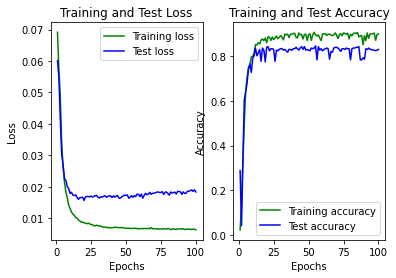

In [13]:
#Running training loop on the data with set parameters
train(
    epochs=100,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    device = device,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)

C:\Users\vladi\AppData\Local\Temp/ipykernel_22052/2368016808.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted  = torch.nn.Softmax()(predicted)
C:\Users\vladi\AppData\Local\Temp/ipykernel_22052/2368016808.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted  = torch.nn.Softmax()(predicted)


Epoch 0, Training loss - 59.223419189453125, Test loss 16.02496337890625
Epoch 1, Training loss - 38.80546188354492, Test loss 10.78962230682373
Epoch 2, Training loss - 26.59019660949707, Test loss 8.248720169067383
Epoch 3, Training loss - 21.109161376953125, Test loss 7.330092906951904
Epoch 4, Training loss - 17.088224411010742, Test loss 6.788804054260254
Epoch 5, Training loss - 14.97659683227539, Test loss 6.340529441833496
Epoch 6, Training loss - 13.276118278503418, Test loss 5.673572540283203
Epoch 7, Training loss - 11.143672943115234, Test loss 5.608119487762451
Epoch 8, Training loss - 10.441773414611816, Test loss 5.865347862243652
Epoch 9, Training loss - 9.19421672821045, Test loss 5.246962547302246


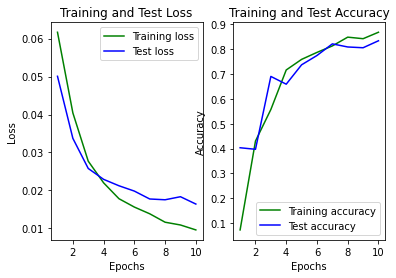

In [14]:
#model retrain
learning_rate = 1e-3
hidden_dim = 200
#Initializing model with nr of features from input
model = LSTMNet(num_words = vocabulary.num_words, hidden_dim = hidden_dim, output_dim = len(train_set['intent'].unique()), batch_size = batch_size, n_layers = 2).to(device)

#Optimizer and loss funtion
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()   

#Running training loop on the data with set parameters
train(
    epochs=10,
    optimizer=optimizer,
    model = model,
    loss_fn = loss_fn,
    device = device,
    print_plot=True,
    train_loader=train_loader,
    test_loader = test_loader
)